# Predicting Bike Rentals

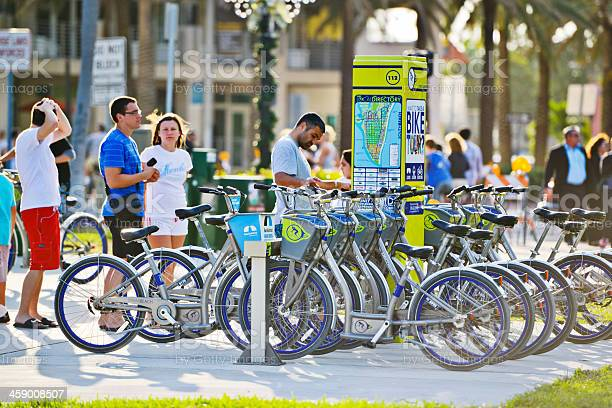

## Introduction
Cho thuê xe đạp theo yêu cầu đã trở thành một xu hướng chính ở các thành phố trên khắp Hoa Kỳ, nơi trong vòng một hoặc hai dặm ở bất cứ nơi nào mà cư dân có thể ở trong thành phố và đặc biệt là các trung tâm thành phố, họ có thể sẽ tìm thấy một ki-ốt cho thuê xe đạp tự phục vụ. Công ty hoặc thành phố có thể thực hiện các cân nhắc để đảm bảo rằng nhu cầu xe đạp được đáp ứng ở đâu và khi nào là nhu cầu cần thiết nhất. Trong dự án này, tôi sẽ cố gắng dự đoán nhu cầu này bằng cách sử dụng linear regression and descision trees.

# Results

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
rentals = pd.read_csv("bike_rental_hour.csv")

In [7]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


# Sau đây là ý nghĩa các column:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
    - 1: clear or few clouds
    - 2: mist or cloudy
    - 3: light rain, light snow, thunderstorm
    - 4: heavy rain, snow, ice pellets, fog
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

In [3]:
rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# I. DATA ANALYST

- Hiện tại không có cột nào ở định dạng datetime, cột 'dteday' đang ở dạng object có ngày, tháng, năm nhưng mình cần nhiều hơn thế
- Mình cần 1 cột ở dạng datetime đầy đủ hơn ít nhất có thêm giờ nữa để thuận tiện cho các bước sau
- Mình sẽ tạo ra 1 cột mới 'datetime' bằng cách cộng chuỗi các cột sau : 'dteday' + ' '+ 'hr' + ':00:00'

In [4]:
rentals['hr'] = rentals['hr'].astype(str)
rentals['datetime'] = rentals['dteday'] + ' ' + rentals['hr']+':00:00'
rentals['hr'] = rentals['hr'].astype(int)
rentals['datetime'] = pd.to_datetime(rentals['datetime'])

In [5]:
rentals['datetime']

0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
3       2011-01-01 03:00:00
4       2011-01-01 04:00:00
                ...        
17374   2012-12-31 19:00:00
17375   2012-12-31 20:00:00
17376   2012-12-31 21:00:00
17377   2012-12-31 22:00:00
17378   2012-12-31 23:00:00
Name: datetime, Length: 17379, dtype: datetime64[ns]

- Đầu tiên mình muốn biết dataset này có record lại đầy đủ tất cả các giờ trong 2 năm 2011-2012 không bằng cách so sánh với số giờ thực tế

In [6]:
two_yr_hr = 2*365*24
length_rentals = len(rentals)
print('dataset:', length_rentals)
print('expected:', two_yr_hr)
print('difference:', two_yr_hr - length_rentals)
print('missing days:', (two_yr_hr-length_rentals)/24)

dataset: 17379
expected: 17520
difference: 141
missing days: 5.875


- Như vậy là dataset đã missing 141 giờ trong vòng 2 năm, khoảng 6 ngày
- Sự chênh lệch này là chấp nhận đc,sẽ ko đủ lớn để ảnh hưởng xấu tới kết quả dự đoán

- Bây giờ mình sẽ visualize ' cnt ' (tổng số lượt thuê xe đạp trong 1 giờ) trên toàn thời gian để có cái nhìn tổng quát trước:

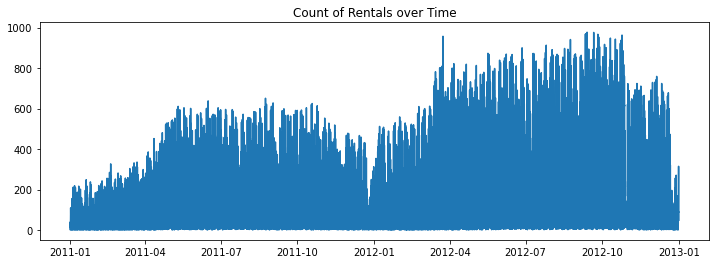

In [7]:
plt.figure(figsize = (12, 4))
plt.plot(rentals['datetime'], rentals['cnt'])
plt.title('Count of Rentals over Time')
plt.show()

- Ấn tượng đầu tiên về việc phân bổ theo thời gian thì là số lượng cho thuê trung bình trong năm 2012 nhiều hơn so với năm 2011.
- Theo tìm hiểu thì Washington D.C. đã mở rộng chương trình 'chia sẻ xe đạp' vào cuối năm 2011, hoàn toàn đúng với biểu đồ trên.

- Bây giờ mình sẽ groupby dữ liệu theo các tháng trong 1 năm, các thứ trong 1 tuần , các giờ trong 1 ngày và sau đó visualize.
- Rất có thể sẽ nhận được nhiều insight bởi vì mỗi thời điểm sẽ có tính chất khác nhau

In [8]:
month_split = rentals.groupby("mnth")[["casual", "registered", "cnt"]].sum()
week_split = rentals.groupby("weekday")[["casual", "registered", "cnt"]].sum()
hour_split = rentals.groupby("hr")[["casual", "registered", "cnt"]].sum()
month_split

,casual,registered,cnt
mnth,,,
1,12042,122891,134933
2,14963,136389,151352
3,44444,184476,228920
4,60802,208292,269094
5,75285,256401,331686
6,73906,272436,346342
7,78157,266791,344948
8,72039,279155,351194
9,70323,275668,345991


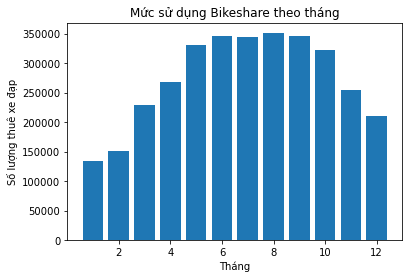

In [9]:
plt.bar(x = list(month_split.index), height = month_split['cnt'])
plt.title('Mức sử dụng Bikeshare theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Số lượng thuê xe đạp')
plt.show()

Ở Mỹ:
+ Mùa Xuân: từ tháng 3 đến tháng 5 là tiết trời ấm áp.
+ Mùa Hạ (Hè):  bắt từ tháng 6 kéo dài dài đến 8 khí hậu nắng - nóng
+ Mùa Thu : từ tháng 8 đến tháng 11 là vào mùa thu mát mẻ trong lành
+ Mùa Đông: là từ tháng 12 đến tháng 2, khí hậu khô – lạnh và có nơi có tuyết rơi.

- Điều này chứng tỏ số lượng thuê xe ảnh hưởng rất nhiều bởi thời tiết, mùa ấm áp sẽ thuê nhiều và ngược lại mùa lạnh sụt giảm

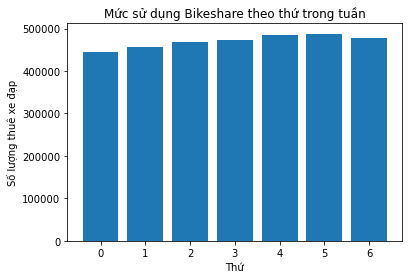

In [10]:
plt.bar(x = week_split.index, height = week_split['cnt'])
plt.title('Mức sử dụng Bikeshare theo thứ trong tuần')
plt.xlabel('Thứ')
plt.ylabel('Số lượng thuê xe đạp')
plt.show()

- Thứ 7, CN (ngày nghỉ) có số lượng thuê ít hơn các thứ khác (ngày làm việc) trong tuần

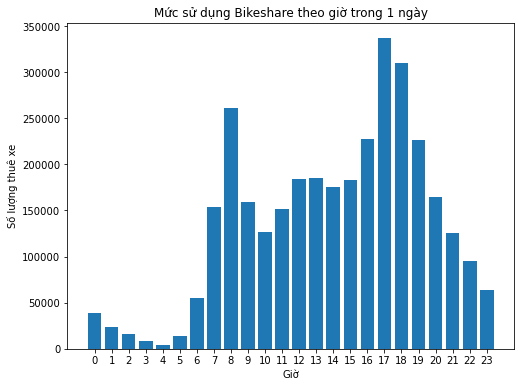

In [11]:
fig, ax = plt.subplots(figsize = (8,6))
ax.bar(hour_split.index, hour_split['cnt'])
plt.xlabel('Giờ')
plt.ylabel('Số lượng thuê xe')
plt.title('Mức sử dụng Bikeshare theo giờ trong 1 ngày')
ax.set_xticks([i for i in range(24)])
plt.show()

- Các giờ trong 1 ngày thì số lượng thuê xe tập trung nhiều vào buổi chiều sau tan làm và buổi sáng lúc mới ngủ dậy bắt đầu đi làm

- Hãy chú ý vào cột 'registered' (đăng ký thuê xe từ trước có nghĩa là có kế hoạch thuê xe từ trước) và cột 'casual' là thông thường - nghĩa là ko đăng ký từ trước

- Mình muốn trực quan hóa dữ liệu thuê xe theo tháng nhưng phân chia theo loại : registered và casual

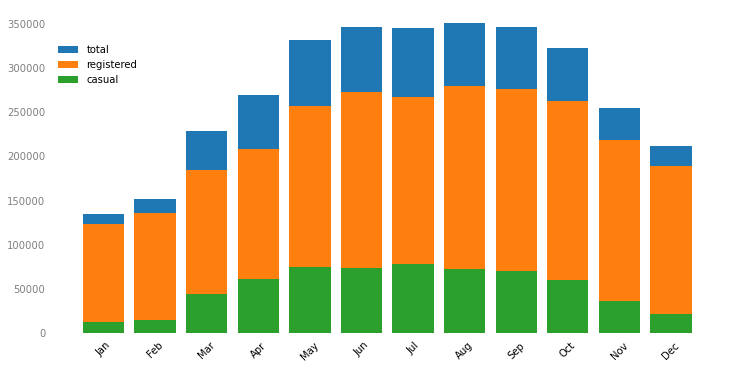

In [22]:
fig, ax = plt.subplots(figsize = (12,6))
ax.bar(month_split.index, month_split['cnt'], label = 'total')
ax.bar(month_split.index, month_split['registered'], label = 'registered')
ax.bar(month_split.index, month_split['casual'], label = 'casual')


ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation = 45)
ax.tick_params(left = False, bottom = False)
ax.tick_params(axis = 'y', colors = 'gray')

for location in ['left','right','top','bottom']:
    ax.spines[location].set_visible(False)

plt.legend(frameon = False, loc=(.003, .75))
plt.show()

- Rút ra được 2 điều từ biểu đồ trên: vào các tháng mùa hè có nhiệt độ ấm thì số lượng thuê xe nhiều hơn, thứ 2 số lượng ng thuê xe có đăng ký trước vượt trội so với ng thuê xe casual
- Có thể lý giải rằng việc đăng ký trước có khả năng là vé tháng, giá thành / 1 lần dùng sẽ rẻ hơn so với không đăng ký trước nên nhiều người đã chọn mua vé tháng

- Tương tự như vậy trực quan hóa số lượng thuê xe theo thứ trong 1 tuần và có phân chia theo nhóm casual và registered

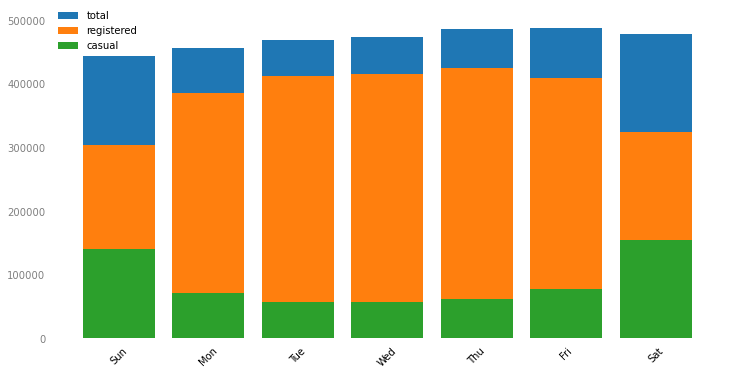

In [27]:
fig, ax = plt.subplots(figsize = (12,6))
ax.bar(week_split.index, week_split['cnt'], label = 'total')
ax.bar(week_split.index, week_split['registered'], label = 'registered')
ax.bar(week_split.index, week_split['casual'], label = 'casual')

#ax.set_yticks([300, 600, 900])
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri','Sat'], rotation = 45)
ax.tick_params(left = False, bottom = False)
ax.tick_params(axis = 'y', colors = 'gray')

for location in ['left','right','top','bottom']:
    ax.spines[location].set_visible(False)

#plt.title('Bikeshare Usage by Day of Week and Usergroup', size = 14, weight = 'bold')
plt.legend(loc = (0.003,0.87), frameon = False)
plt.show()

- Từ biểu đồ trên ta thấy thứ 7 và CN thì số ng thuê có đăng ký so với thuê bình thường là tương đồng nhau, còn các thứ là ngày làm việc thì số ng thuê đăng ký trước vượt trội
- Chứng tỏ rằng những ng thuê có đăng ký trước (có khả năng mua vé tháng ) thì sẽ thuê nhiều vào ngày làm việc hay nói cách khác chủ đích mua vé tháng là dùng cho đi làm, vào những thứ ko phải cuối tuần

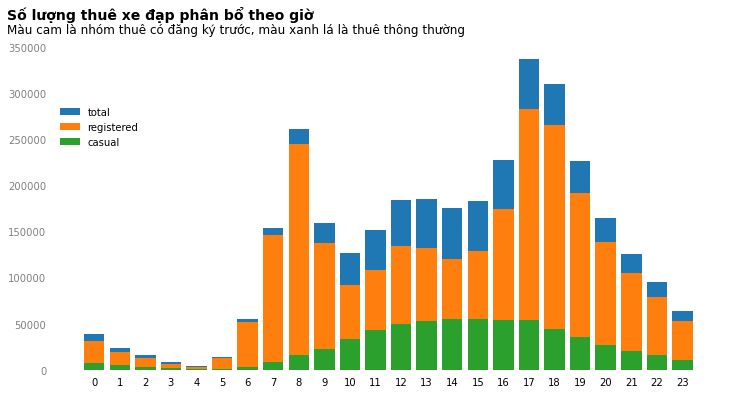

In [28]:
fig, ax = plt.subplots(figsize = (12,6))
ax.bar(hour_split.index, hour_split['cnt'], label = 'total')
ax.bar(hour_split.index, hour_split['registered'], label = 'registered')
ax.bar(hour_split.index, hour_split['casual'], label = 'casual')

#ax.set_ylim([0,1200])
#ax.set_yticks([300, 600, 900])
ax.set_xticks(list(range(0,24)))
ax.set_xticklabels(list(range(0,24)))
ax.tick_params(left = False, bottom = False)
ax.tick_params(axis = 'y', colors = 'gray')

for location in ['left','right','top','bottom']:
    ax.spines[location].set_visible(False)
ax.text(-3.4, 380000, 'Số lượng thuê xe đạp phân bổ theo giờ', size=14, weight='bold')
ax.text(-3.4, 365000, 'Màu cam là nhóm thuê có đăng ký trước, màu xanh lá là thuê thông thường', size=12)
plt.legend(loc = (0.003,0.67), frameon = False)

plt.show()

- Hành vi của các nhóm người dùng thuê xe đạp (registered/casual)  là khác nhau khi chia nhỏ theo thời gian, chưa nhìn thấy 1 xu hướng nào rõ ràng từ 2 nhóm người trên
- Do đó, chúng tacó thể nhận được kết quả chính xác hơn nếu chúng tôi dự đoán việc sử dụng các nhóm này hơn là chỉ nhắm vào tổng mức sử dụng.

- Tiếp tục groupby data theo nhiệt độ, độ ẩm, gió và sau đó visualize để tìm insight:

In [29]:
temp_split = rentals.groupby("temp")[["casual", "registered", "cnt"]].sum()
atemp_split = rentals.groupby("atemp")[["casual", "registered", "cnt"]].sum()
hum_split = rentals.groupby("hum")[["casual", "registered", "cnt"]].sum()
windspeed_split = rentals.groupby("windspeed")[["casual", "registered", "cnt"]].sum()

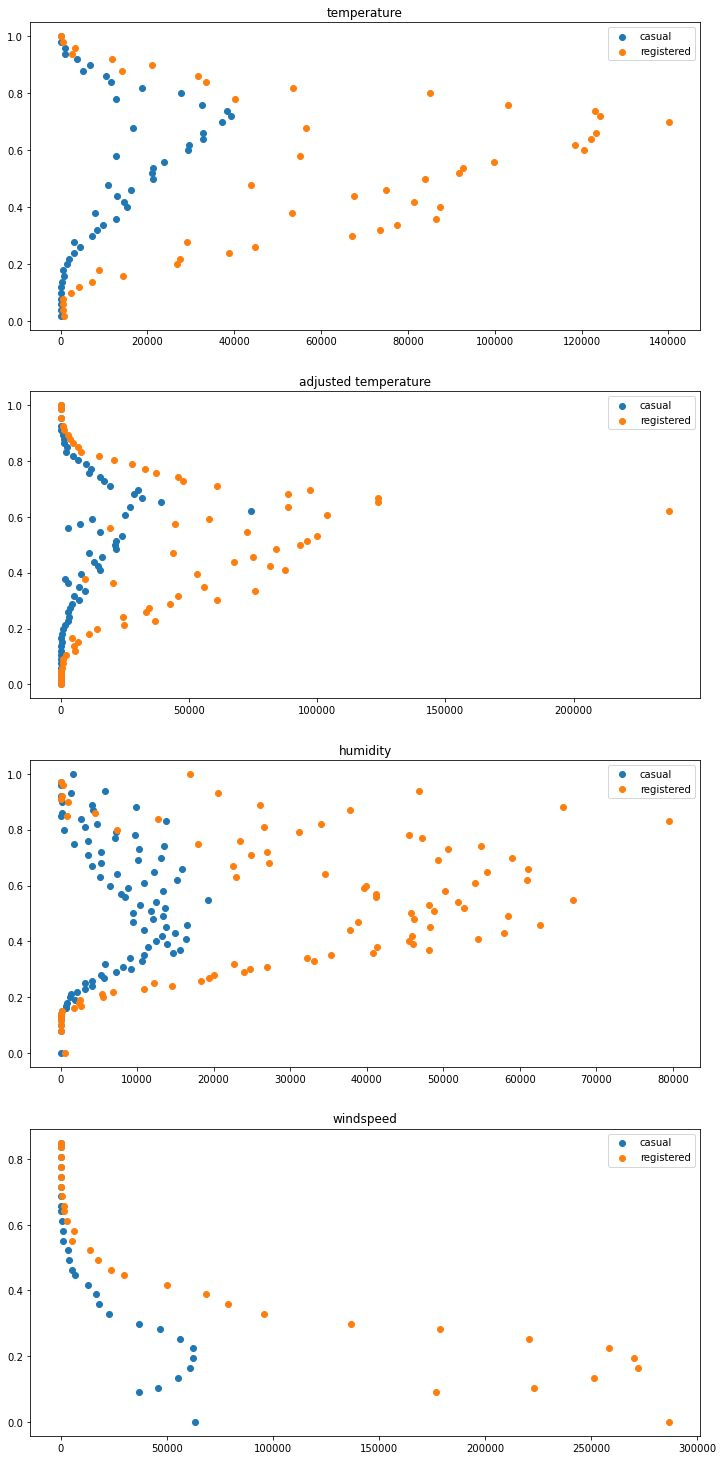

In [30]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, ncols = 1, figsize = (12,26))

for weather_feature, axes, title in zip([temp_split, atemp_split, hum_split, windspeed_split], [ax1, ax2, ax3, ax4], ['temperature','adjusted temperature', 'humidity','windspeed']):
    axes.set_title(title)
    for group in ['casual', 'registered']:
        axes.scatter(weather_feature[group], weather_feature.index, label = group)
    axes.legend()
        

plt.show()
                                 

- Suy ra thời tiết khắc nghiệt /cực đoan sẽ làm giảm lượng thuê xe

## Feature Selection
Chúng ta sẽ tiếp tục với kế hoạch tạo ra các dự đoán riêng biệt cho 'cnt','registered' và 'casual'. Chúng ta sẽ cần lặp lại quy trình lựa chọn tính năng cho từng danh mục.


#### Giờ cao điểm
Người dùng đã đăng ký có nhiều khả năng sử dụng xe đạp hơn trong giờ đi làm. Chúng tôi sẽ xác định giờ đi làm là giờ từ 7:00 đến 9:00 và từ 16:00 đến 19:00.

In [31]:
def rush_hour(time):
    if time in [7,8,9,16,17,18,19]:
        return True
    else:
        return False
rentals['rush_hour'] = rentals['hr'].apply(rush_hour)

Buổi chiều
Nhóm người thuê casual có nhiều khả năng sử dụng xe đạp hơn vào buổi chiều. Chúng tôi sẽ xác định buổi chiều là khoảng thời gian từ 11:00 đến 18:00.

In [32]:
def afternoon(time):
    if time in [11,12,13,14,15,16,17,18]:
        return True
    else:
        return False
rentals['afternoon'] = rentals['hr'].apply(afternoon)

#### Đêm
Cả hai nhóm đều thuê ít vào ban đêm.

In [33]:
def night(time):
    if time in [0,1,2,3,4,5]:
        return True
    else:
        return False
rentals['night'] = rentals['hr'].apply(night)

#### General Time Frames
Let's create some general groupings for the time of day.

In [34]:
def time_label(time):
    if time in [6,7,8,9,10,11]:
        return 1
    elif time in [12,13,14,15,16,17]:
        return 2
    elif time in [18, 19, 20, 21, 22, 23]:
        return 3
    else:
        return 4

In [35]:
rentals['time_bin'] = rentals['hr'].apply(time_label)

#### Humidity
Let's categorize days that are too extreme on the humidity scale.

In [37]:
def nice_humidity(humidity):
    if humidity <= .2 or humidity >= .8:
        return False
    else:
        return True

rentals['nice_humidity'] = rentals['hum'].apply(nice_humidity)

#### Windspeed
Windy days has a negative effect on bikeshare usage.

In [38]:
def too_windy(windspeed):
    if windspeed > .3:
        return True
    else:
        return False

In [39]:
rentals['too_windy'] = rentals['windspeed'].apply(too_windy)

#### Temperature
If the temperature is not ideal.

In [40]:
def nice_temp(temperature):
    if temperature <= .2 or temperature >= .8:
        return False
    else:
        return True
rentals['nice_temp'] = rentals['temp'].apply(nice_temp)

### Target Correlations
One basic way to identify which columns will be good feature candidates for our machine learning algorithms is to look at correlations with the target metric. Too many features can result in an overfit model, so fewer, but well correlated features are usually desirable.

#### Total Count Correlations

In [41]:
cnt_feature_correlations = abs(rentals.corr()['cnt'].drop(['cnt', 'instant', 'registered','casual'])).sort_values(ascending = False)
cnt_feature_correlations

night            0.518261
rush_hour        0.494793
afternoon        0.436234
temp             0.404772
atemp            0.400929
hr               0.394071
time_bin         0.378318
hum              0.322911
yr               0.250495
nice_humidity    0.249086
season           0.178056
weathersit       0.142426
mnth             0.120638
windspeed        0.093234
too_windy        0.032652
holiday          0.030927
workingday       0.030284
weekday          0.026900
nice_temp        0.014802
Name: cnt, dtype: float64

#### Casual User Correlations

In [42]:
cas_feature_correlations = abs(rentals.corr()['casual'].drop(['cnt', 'instant', 'registered','casual'])).sort_values(ascending = False)
cas_feature_correlations

afternoon        0.494287
temp             0.459616
atemp            0.454080
night            0.361136
hum              0.347028
hr               0.301202
workingday       0.300942
time_bin         0.250076
nice_humidity    0.248985
weathersit       0.152628
yr               0.142779
rush_hour        0.134504
season           0.120206
windspeed        0.090287
mnth             0.068457
nice_temp        0.053703
weekday          0.032721
holiday          0.031564
too_windy        0.025270
Name: casual, dtype: float64

#### Registered User Correlations

In [43]:
reg_feature_correlations = abs(rentals.corr()['registered'].drop(['cnt', 'instant', 'registered','casual'])).sort_values(ascending = False)
reg_feature_correlations

rush_hour        0.549149
night            0.503446
hr               0.374141
time_bin         0.371916
afternoon        0.361771
temp             0.335361
atemp            0.332559
hum              0.273933
yr               0.253684
nice_humidity    0.217399
season           0.174226
workingday       0.134326
mnth             0.122273
weathersit       0.120966
windspeed        0.082321
holiday          0.047345
too_windy        0.030899
weekday          0.021578
nice_temp        0.000245
Name: registered, dtype: float64

In [44]:
rentals

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,registered,cnt,datetime,rush_hour,afternoon,night,time_bin,nice_humidity,too_windy,nice_temp
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,13,16,2011-01-01 00:00:00,False,False,True,4,False,False,True
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,32,40,2011-01-01 01:00:00,False,False,True,4,False,False,True
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,27,32,2011-01-01 02:00:00,False,False,True,4,False,False,True
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,10,13,2011-01-01 03:00:00,False,False,True,4,True,False,True
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,1,1,2011-01-01 04:00:00,False,False,True,4,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,...,108,119,2012-12-31 19:00:00,True,False,False,3,True,False,True
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,...,81,89,2012-12-31 20:00:00,False,False,False,3,True,False,True
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,...,83,90,2012-12-31 21:00:00,False,False,False,3,True,False,True
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,...,48,61,2012-12-31 22:00:00,False,False,False,3,True,False,True


## II. Predictive Models

húng tôi sẽ sử dụng một loạt mô hình dự đoán để kiểm tra xem mô hình nào hoạt động tốt nhất trong việc dự đoán mức sử dụng chia sẻ xe đạp. 
Các giá trị mà chúng tôi sẽ dự đoán là 'cnt','registered' và 'casual'


### Hồi quy tuyến tính
Chúng ta sẽ bắt đầu với một mô hình hồi quy tuyến tính cơ bản. Với mô hình hồi quy tuyến tính, các tính năng bạn chọn sẽ có tác động cao nhất đến hiệu suất của mô hình.

Chúng tôi sẽ sử dụng phương pháp đánh giá tính năng lặp lại lựa chọn chuyển tiếp để chọn các tính năng tốt nhất cho mỗi nhóm.

In [45]:
# all features to be evaluated
feature_start = np.array(rentals.columns.drop(['instant', 'casual', 'registered', 'cnt', 'dteday', 'datetime']))

# forward feature selection for cnt
sfs = SFS(LinearRegression(),  direction = 'forward', scoring = "neg_mean_squared_error", cv = 10)
sfs_forward_cnt = sfs.fit(rentals[feature_start], rentals['cnt'])
best_cnt_features = feature_start[sfs_forward_cnt.get_support()]

In [46]:
# forward feature selection for registered
sfs = SFS(LinearRegression(),  direction = 'forward', scoring = "neg_mean_squared_error", cv = 10)
sfs_forward_casual = sfs.fit(rentals[feature_start], rentals['casual'])
best_casual_features = feature_start[sfs_forward_casual.get_support()]

In [47]:
# forward feature selection for casual
sfs = SFS(LinearRegression(),  direction = 'forward', scoring = "neg_mean_squared_error", cv = 10)
sfs_forward_registered = sfs.fit(rentals[feature_start], rentals['registered'])
best_registered_features = feature_start[sfs_forward_registered.get_support()]

In [48]:
print("Best cnt Features:", best_cnt_features)
print("Best casual Features:", best_casual_features)
print("Best registered Features:", best_registered_features)

Best cnt Features: ['season' 'yr' 'weathersit' 'temp' 'hum' 'rush_hour' 'afternoon' 'night'
 'time_bin']
Best casual Features: ['yr' 'holiday' 'weekday' 'workingday' 'weathersit' 'temp' 'hum'
 'afternoon' 'night']
Best registered Features: ['season' 'yr' 'workingday' 'weathersit' 'atemp' 'rush_hour' 'afternoon'
 'night' 'time_bin']


In [49]:
def train_test(df, features, target):
    model = LinearRegression()
    
    train = df.sample(frac = .8, replace = False, random_state = 1)
    test = df.loc[~df.index.isin(train.index)]
    
    model.fit(train[features],train[target])
            
    predictions = model.predict(test[features])

    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    r2 = r2_score(test[target], predictions)
    mae = mean_absolute_error(test[target], predictions)
    
    return rmse, mae, r2

In [50]:
total_rmse, total_mae, total_r2 = train_test(rentals, best_cnt_features, target = 'cnt')
casual_rmse, casual_mae, casual_r2 = train_test(rentals, best_casual_features, target = 'casual')
registered_rmse, registered_mae, registered_r2 = train_test(rentals, best_registered_features, target = 'registered')

In [51]:
model_evaluation = pd.DataFrame(data = {'Model': ['Linear Regression','Linear Regression','Linear Regression'], 
                                         'Iteration':['Base','Base','Base'], 
                                         'Cohort': ['total', 'casual', 'registered'],
                                         'RMSE': [total_rmse, casual_rmse, registered_rmse],
                                         'MAE': [total_mae, casual_mae, registered_mae],
                                         'R2': [total_r2, casual_r2, registered_r2]})

model_evaluation

,Model,Iteration,Cohort,RMSE,MAE,R2
0,Linear Regression,Base,total,111.241362,82.477906,0.609724
1,Linear Regression,Base,casual,33.219344,23.122334,0.537638
2,Linear Regression,Base,registered,94.195793,69.441194,0.594278


In [52]:
def kfold_model(df, features, target):
    model = LinearRegression()
    
    kf = KFold(10, shuffle = True, random_state = 1)
            
    mses = cross_val_score(model, df[features], df[target], scoring = "neg_mean_squared_error", cv = kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    
    r2 = cross_val_score(model, df[features], df[target], scoring = "r2", cv = kf)
    avg_r2 = np.mean(r2)
    
    mae = abs(cross_val_score(model, df[features], df[target], scoring = "neg_mean_absolute_error", cv = kf))
    avg_mae = np.mean(mae)
    
    return avg_rmse, avg_mae, avg_r2

In [53]:
total_rmse, total_mae, total_r2 = kfold_model(rentals, best_cnt_features, target = 'cnt')
casual_rmse, casual_mae, casual_r2 = kfold_model(rentals, best_casual_features, target = 'casual')
registered_rmse, registered_mae, registered_r2 = kfold_model(rentals, best_registered_features, target = 'registered')

In [54]:
model_evaluation_2 = pd.DataFrame(data = {'Model': ['Linear Regression','Linear Regression','Linear Regression'], 
                                         'Iteration':['K-fold','K-fold','K-fold'], 
                                         'Cohort': ['total', 'casual', 'registered'],
                                         'RMSE': [total_rmse, casual_rmse, registered_rmse],
                                         'MAE': [total_mae, casual_mae, registered_mae],
                                         'R2': [total_r2, casual_r2, registered_r2]})

model_evaluation = model_evaluation.append(model_evaluation_2)
model_evaluation = model_evaluation.reset_index(drop = True)
model_evaluation

C:\Users\Do Quang Dao\AppData\Local\Temp\ipykernel_1224\1051160952.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evaluation = model_evaluation.append(model_evaluation_2)


,Model,Iteration,Cohort,RMSE,MAE,R2
0,Linear Regression,Base,total,111.241362,82.477906,0.609724
1,Linear Regression,Base,casual,33.219344,23.122334,0.537638
2,Linear Regression,Base,registered,94.195793,69.441194,0.594278
3,Linear Regression,K-fold,total,111.371543,82.273253,0.622235
4,Linear Regression,K-fold,casual,33.203748,22.896430,0.545565
5,Linear Regression,K-fold,registered,94.967519,69.524097,0.605244


# Decision Tree Regression

In [56]:
def decision_tree(df, features, target):
    model = DecisionTreeRegressor(random_state = 1)
    
    train = df.sample(frac = .8, replace = False, random_state = 1)
    test = df.loc[~df.index.isin(train.index)]
    
    model.fit(train[features],train[target])
            
    predictions = model.predict(test[features])

    # calculate RMSE of predictions and actual prices
    
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    r2 = r2_score(test[target], predictions)
    mae = mean_absolute_error(test[target], predictions)
    
    return rmse, mae, r2

In [57]:
total_rmse, total_mae, total_r2 = decision_tree(rentals, feature_start, target = 'cnt')
casual_rmse, casual_mae, casual_r2 = decision_tree(rentals, feature_start, target = 'casual')
registered_rmse, registered_mae, registered_r2 = decision_tree(rentals, feature_start, target = 'registered')

In [58]:
model_evaluation_3 = pd.DataFrame(data = {'Model': ['Decision Tree','Decision Tree','Decision Tree'], 
                                         'Iteration':['Base','Base','Base'], 
                                         'Cohort': ['total', 'casual', 'registered'],
                                         'RMSE': [total_rmse, casual_rmse, registered_rmse],
                                         'MAE': [total_mae, casual_mae, registered_mae],
                                         'R2': [total_r2, casual_r2, registered_r2]})

model_evaluation = model_evaluation.append(model_evaluation_3)
model_evaluation = model_evaluation.reset_index(drop = True)
model_evaluation

C:\Users\Do Quang Dao\AppData\Local\Temp\ipykernel_1224\402735263.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evaluation = model_evaluation.append(model_evaluation_3)


,Model,Iteration,Cohort,RMSE,MAE,R2
0,Linear Regression,Base,total,111.241362,82.477906,0.609724
1,Linear Regression,Base,casual,33.219344,23.122334,0.537638
2,Linear Regression,Base,registered,94.195793,69.441194,0.594278
3,Linear Regression,K-fold,total,111.371543,82.273253,0.622235
4,Linear Regression,K-fold,casual,33.203748,22.896430,0.545565
5,Linear Regression,K-fold,registered,94.967519,69.524097,0.605244
6,Decision Tree,Base,total,59.892801,35.564298,0.886867
7,Decision Tree,Base,casual,20.111817,11.603280,0.830526
8,Decision Tree,Base,registered,49.871060,27.759350,0.886273


In [59]:
def decision_tree(df, features, target):
    model = DecisionTreeRegressor(random_state = 1, min_samples_leaf = 7)
    
    train = df.sample(frac = .8, replace = False, random_state = 1)
    test = df.loc[~df.index.isin(train.index)]
    
    model.fit(train[features],train[target])
            
    predictions = model.predict(test[features])

    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    r2 = r2_score(test[target], predictions)
    mae = mean_absolute_error(test[target], predictions)
    
    return rmse, mae, r2

In [60]:
total_rmse, total_mae, total_r2 = decision_tree(rentals, feature_start, target = 'cnt')
casual_rmse, casual_mae, casual_r2 = decision_tree(rentals, feature_start, target = 'casual')
registered_rmse, registered_mae, registered_r2 = decision_tree(rentals, feature_start, target = 'registered')

In [61]:
model_evaluation_4 = pd.DataFrame(data = {'Model': ['Decision Tree','Decision Tree','Decision Tree'], 
                                         'Iteration':['Min Samples Leaf 7','Min Samples Leaf 7','Min Samples Leaf 7'], 
                                         'Cohort': ['total', 'casual', 'registered'],
                                         'RMSE': [total_rmse, casual_rmse, registered_rmse],
                                         'MAE': [total_mae, casual_mae, registered_mae],
                                         'R2': [total_r2, casual_r2, registered_r2]})

model_evaluation = model_evaluation.append(model_evaluation_4)
model_evaluation = model_evaluation.reset_index(drop = True)
model_evaluation

C:\Users\Do Quang Dao\AppData\Local\Temp\ipykernel_1224\1983501566.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evaluation = model_evaluation.append(model_evaluation_4)


,Model,Iteration,Cohort,RMSE,MAE,R2
0,Linear Regression,Base,total,111.241362,82.477906,0.609724
1,Linear Regression,Base,casual,33.219344,23.122334,0.537638
2,Linear Regression,Base,registered,94.195793,69.441194,0.594278
3,Linear Regression,K-fold,total,111.371543,82.273253,0.622235
4,Linear Regression,K-fold,casual,33.203748,22.896430,0.545565
5,Linear Regression,K-fold,registered,94.967519,69.524097,0.605244
6,Decision Tree,Base,total,59.892801,35.564298,0.886867
7,Decision Tree,Base,casual,20.111817,11.603280,0.830526
8,Decision Tree,Base,registered,49.871060,27.759350,0.886273
9,Decision Tree,Min Samples Leaf 7,total,53.356605,32.482485,0.910213


### Random Forest Regression

In [62]:
def random_forest(df, features, target):
    model = RandomForestRegressor(random_state = 1)
    
    train = df.sample(frac = .8, replace = False, random_state = 1)
    test = df.loc[~df.index.isin(train.index)]
    
    model.fit(train[features],train[target])
            
    predictions = model.predict(test[features])

    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    r2 = r2_score(test[target], predictions)
    mae = mean_absolute_error(test[target], predictions)
    
    return rmse, mae, r2

In [63]:
total_rmse, total_mae, total_r2 = random_forest(rentals, feature_start, target = 'cnt')
casual_rmse, casual_mae, casual_r2 = random_forest(rentals, feature_start, target = 'casual')
registered_rmse, registered_mae, registered_r2 = random_forest(rentals, feature_start, target = 'registered')

In [64]:
model_evaluation_5 = pd.DataFrame(data = {'Model': ['Random Forest','Random Forest','Random Forest'], 
                                         'Iteration':['Base','Base','Base'], 
                                         'Cohort': ['total', 'casual', 'registered'],
                                         'RMSE': [total_rmse, casual_rmse, registered_rmse],
                                         'MAE': [total_mae, casual_mae, registered_mae],
                                         'R2': [total_r2, casual_r2, registered_r2]})

model_evaluation = model_evaluation.append(model_evaluation_5)
model_evaluation = model_evaluation.reset_index(drop = True)
model_evaluation

C:\Users\Do Quang Dao\AppData\Local\Temp\ipykernel_1224\3363039502.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evaluation = model_evaluation.append(model_evaluation_5)


,Model,Iteration,Cohort,RMSE,MAE,R2
0,Linear Regression,Base,total,111.241362,82.477906,0.609724
1,Linear Regression,Base,casual,33.219344,23.122334,0.537638
2,Linear Regression,Base,registered,94.195793,69.441194,0.594278
3,Linear Regression,K-fold,total,111.371543,82.273253,0.622235
4,Linear Regression,K-fold,casual,33.203748,22.896430,0.545565
5,Linear Regression,K-fold,registered,94.967519,69.524097,0.605244
6,Decision Tree,Base,total,59.892801,35.564298,0.886867
7,Decision Tree,Base,casual,20.111817,11.603280,0.830526
8,Decision Tree,Base,registered,49.871060,27.759350,0.886273
9,Decision Tree,Min Samples Leaf 7,total,53.356605,32.482485,0.910213


In [65]:
def random_forest(df, features, target):
    model = RandomForestRegressor(random_state = 1, n_estimators = 350)
    
    train = df.sample(frac = .8, replace = False, random_state = 1)
    test = df.loc[~df.index.isin(train.index)]
    
    model.fit(train[features],train[target])
            
    predictions = model.predict(test[features])

    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    r2 = r2_score(test[target], predictions)
    mae = mean_absolute_error(test[target], predictions)
    
    return rmse, mae, r2

In [66]:
total_rmse, total_mae, total_r2 = random_forest(rentals, feature_start, target = 'cnt')
casual_rmse, casual_mae, casual_r2 = random_forest(rentals, feature_start, target = 'casual')
registered_rmse, registered_mae, registered_r2 = random_forest(rentals, feature_start, target = 'registered')

In [67]:
model_evaluation_6 = pd.DataFrame(data = {'Model': ['Random Forest','Random Forest','Random Forest'], 
                                         'Iteration':['350 Estimators', '350 Estimators', '350 Estimators'], 
                                         'Cohort': ['total', 'casual', 'registered'],
                                         'RMSE': [total_rmse, casual_rmse, registered_rmse],
                                         'MAE': [total_mae, casual_mae, registered_mae],
                                         'R2': [total_r2, casual_r2, registered_r2]})

model_evaluation = model_evaluation.append(model_evaluation_6)
model_evaluation = model_evaluation.reset_index(drop = True)
model_evaluation

C:\Users\Do Quang Dao\AppData\Local\Temp\ipykernel_1224\4247201291.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evaluation = model_evaluation.append(model_evaluation_6)


,Model,Iteration,Cohort,RMSE,MAE,R2
0,Linear Regression,Base,total,111.241362,82.477906,0.609724
1,Linear Regression,Base,casual,33.219344,23.122334,0.537638
2,Linear Regression,Base,registered,94.195793,69.441194,0.594278
3,Linear Regression,K-fold,total,111.371543,82.273253,0.622235
4,Linear Regression,K-fold,casual,33.203748,22.896430,0.545565
5,Linear Regression,K-fold,registered,94.967519,69.524097,0.605244
6,Decision Tree,Base,total,59.892801,35.564298,0.886867
7,Decision Tree,Base,casual,20.111817,11.603280,0.830526
8,Decision Tree,Base,registered,49.871060,27.759350,0.886273
9,Decision Tree,Min Samples Leaf 7,total,53.356605,32.482485,0.910213
